# Prepare the dataset

This is a standard data prep task. We are going to download the coco dataset

## Download the raw data

In [ ]:
# run this on the terminal
! bash download_data.sh

In [16]:
# need this dependency for plotting
! pip install matplotlib --quiet

## Let's look at some stats of the data

In [1]:
import os
import pandas as pd
import json

In [2]:
# Path to the image folders
train_images_path = "train2017"
val_images_path = "val2017"

# Path to the annotations folder
annotations_path = "annotations"

# List the contents of the image folders
train_images_list = os.listdir(train_images_path)
val_images_list = os.listdir(val_images_path)

# Display the number of images in each folder
print(f"Number of images in train2017: {len(train_images_list)}")
print(f"Number of images in val2017: {len(val_images_list)}")

Number of images in train2017: 118287
Number of images in val2017: 5000


In [5]:

# Path to the JSON file
captions_train_path = "annotations/captions_train2017.json"

# Read JSON file into a dataframe
with open(captions_train_path, 'r') as f:
    captions_train_data = json.load(f)

# Flatten the nested structure
captions_train_df = pd.json_normalize(captions_train_data['annotations'], sep='_')

# Display basic information about the dataframe
print(f"Number of entries in Captions Train: {len(captions_train_df)}")
print(f"Columns: {list(captions_train_df.columns)}")
print(f"\nSample data:\n{captions_train_df.head()}")


Number of entries in Captions Train: 591753
Columns: ['image_id', 'id', 'caption']

Sample data:
   image_id   id                                            caption
0    203564   37  A bicycle replica with a clock as the front wh...
1    322141   49  A room with blue walls and a white sink and door.
2     16977   89  A car that seems to be parked illegally behind...
3    106140   98  A large passenger airplane flying through the ...
4    106140  101  There is a GOL plane taking off in a partly cl...


In [6]:
# Path to the JSON file
captions_val_path = "annotations/captions_val2017.json"

# Read JSON file into a dataframe
with open(captions_val_path, 'r') as f:
    captions_val_data = json.load(f)

# Flatten the nested structure
captions_val_df = pd.json_normalize(captions_val_data['annotations'], sep='_')

# Display basic information about the dataframe
print(f"Number of entries in Captions Validation: {len(captions_val_df)}")
print(f"Columns: {list(captions_val_df.columns)}")
print(f"\nSample data:\n{captions_val_df.head()}")


Number of entries in Captions Validation: 25014
Columns: ['image_id', 'id', 'caption']

Sample data:
   image_id   id                                            caption
0    179765   38  A black Honda motorcycle parked in front of a ...
1    179765  182      A Honda motorcycle parked in a grass driveway
2    190236  401  An office cubicle with four different types of...
3    331352  441          A small closed toilet in a cramped space.
4    517069  447     Two women waiting at a bench next to a street.


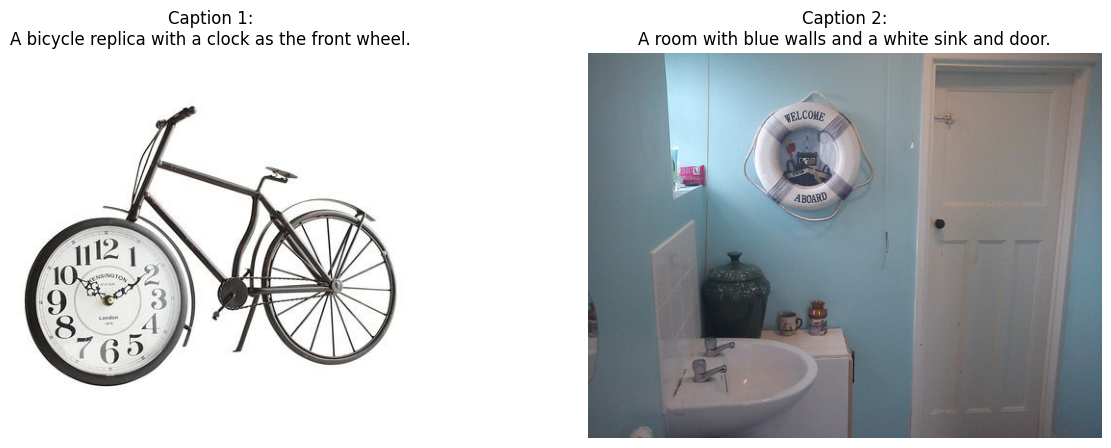

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

# Path to the train2017 images directory
images_dir = "train2017/"

# Provided image IDs and captions
image_ids = [203564, 322141]
captions = [
    'A bicycle replica with a clock as the front wheel.',
    'A room with blue walls and a white sink and door.'
]

# Function to display images with captions
def display_images_with_captions(image_paths, captions):
    fig, axes = plt.subplots(1, len(image_paths), figsize=(15, 5))

    for i, (image_path, caption) in enumerate(zip(image_paths, captions)):
        img = mpimg.imread(os.path.join(images_dir, image_path))
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"Caption {i + 1}:\n{caption}")

    plt.show()

# Display images with captions for the provided IDs
image_paths = [f"{image_id:012d}.jpg" for image_id in image_ids]
display_images_with_captions(image_paths, captions)

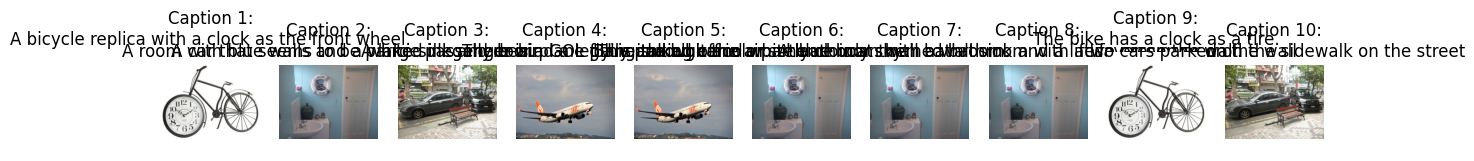

In [21]:
# Function to display images with captions for specific image IDs
def display_images_with_captions_by_ids(image_ids, dataframe):
    image_paths = [f"{image_id:012d}.jpg" for image_id in image_ids]
    captions = dataframe[dataframe['image_id'].isin(image_ids)]['caption'].tolist()
    display_images_with_captions(image_paths, captions)

# Get the first 10 image IDs and captions from the DataFrame
first_10_image_ids = captions_train_df.head(10)['image_id'].tolist()

# Display images with captions for the first 10 image IDs
display_images_with_captions_by_ids(first_10_image_ids, captions_train_df)


In [27]:
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set the random seed for reproducibility
random.seed(1234)

NUM_IMAGES_TO_PLOT = 10
MAX_CAPTIONS_PER_IMAGE = 4

# Function to save images with captions for specific image IDs (limit to 4 captions)
def save_images_with_captions(image_ids, dataframe, max_captions=4, save_folder="previews"):
    # Create the save folder if it doesn't exist
    os.makedirs(save_folder, exist_ok=True)

    for image_id in image_ids:
        # Get image path and up to 4 captions
        image_path = f"{image_id:012d}.jpg"
        captions = dataframe[dataframe['image_id'] == image_id]['caption'].tolist()[:max_captions]

        # Loop over captions and save separate images for each
        for i, caption in enumerate(captions):
            # Read and plot the image
            img = mpimg.imread(os.path.join(images_dir, image_path))
            plt.imshow(img)
            plt.axis('off')
            plt.title(caption)

            # Save the image with the caption as the filename
            save_path = os.path.join(save_folder, f"{image_id}_{i + 1}.png")
            plt.savefig(save_path, bbox_inches='tight')
            plt.close()

# Get the first 10 unique image IDs from the DataFrame
first_10_unique_image_ids = captions_train_df['image_id'].unique()[:NUM_IMAGES_TO_PLOT]

# Save images with up to 4 captions for each of the first 10 unique image IDs
save_images_with_captions(first_10_unique_image_ids, captions_train_df, max_captions=MAX_CAPTIONS_PER_IMAGE)


In [28]:
! echo "Number of images in previews: $(ls -1 previews | wc -l)"

Number of images in previews: 40


## Create the dataset object

In [63]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import json
import pandas as pd
import clip

class ImageTextDataset(Dataset):
    def __init__(self, images_folder, annotations_path, tokenize, max_captions=4, transform=None):
        self.images_folder = images_folder
        self.annotations_df = self.load_annotations(annotations_path, max_captions)
        self.transform = transform
        self.tokenize = tokenize

    def __len__(self):
        return len(self.annotations_df)

    def __getitem__(self, idx):
        img_name, captions = self.annotations_df.iloc[idx]
        img_path = os.path.join(self.images_folder, f"{img_name:012d}.jpg")
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)
        
        annotation = self.tokenize(captions[0])

        return image, annotation

    def load_annotations(self, annotations_path, max_captions):
        with open(annotations_path, 'r') as f:
            annotations_data = json.load(f)

        # Flatten the nested structure and select relevant columns
        annotations_df = pd.json_normalize(annotations_data['annotations'], sep='_')[['image_id', 'caption']]

        # Combine multiple captions for the same image
        annotations_df = annotations_df.groupby('image_id')['caption'].apply(list).reset_index(name='captions')

        # Limit the number of captions per image
        annotations_df['captions'] = annotations_df['captions'].apply(lambda x: x[:max_captions])

        return annotations_df

# Custom collate function to handle non-tensor data types
def custom_collate(batch):
    images, captions = zip(*batch)
    images = torch.stack([transforms.ToTensor()(img) for img in images])
    return images, captions

# Resize and crop the images to 256x256
image_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((256, 256)),
])

# Example usage:
# Specify the paths to your image folders and annotation JSON file
train_images_path = "train2017"
val_images_path = "val2017"
captions_train_path = "annotations/captions_train2017.json"
captions_val_path = "annotations/captions_val2017.json"  # Update this line

# Instantiate the dataset with the CLIP tokenizer and image transform
train_dataset = ImageTextDataset(images_folder=train_images_path, annotations_path=captions_train_path, max_captions=4, transform=image_transform, tokenize=clip.tokenize)
val_dataset = ImageTextDataset(images_folder=val_images_path, annotations_path=captions_val_path, max_captions=4, transform=image_transform, tokenize=clip.tokenize)

# Example usage of DataLoader with custom collate function
train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=True, collate_fn=custom_collate)

## Verify
Let's look at a few examples to make sure we didn't mess up the data as we loaded it

In [66]:
# Iterate over batches (train dataset)
for train_images, train_captions in train_dataloader:
    print("Train - Image shape:", images.shape)
    print("Train - Captions:", captions[0].shape)
    break  # Break after printing the first batch for demonstration

# Iterate over batches (val dataset)
for val_images, val_captions in val_dataloader:
    print("Val - Image shape:", images.shape)
    print("Val - Captions:", captions[0].shape)
    break  # Break after printing the first batch for demonstration

Train - Image shape: torch.Size([1, 3, 256, 256])
Train - Captions: torch.Size([1, 77])
Val - Image shape: torch.Size([1, 3, 256, 256])
Val - Captions: torch.Size([1, 77])


Now plot it

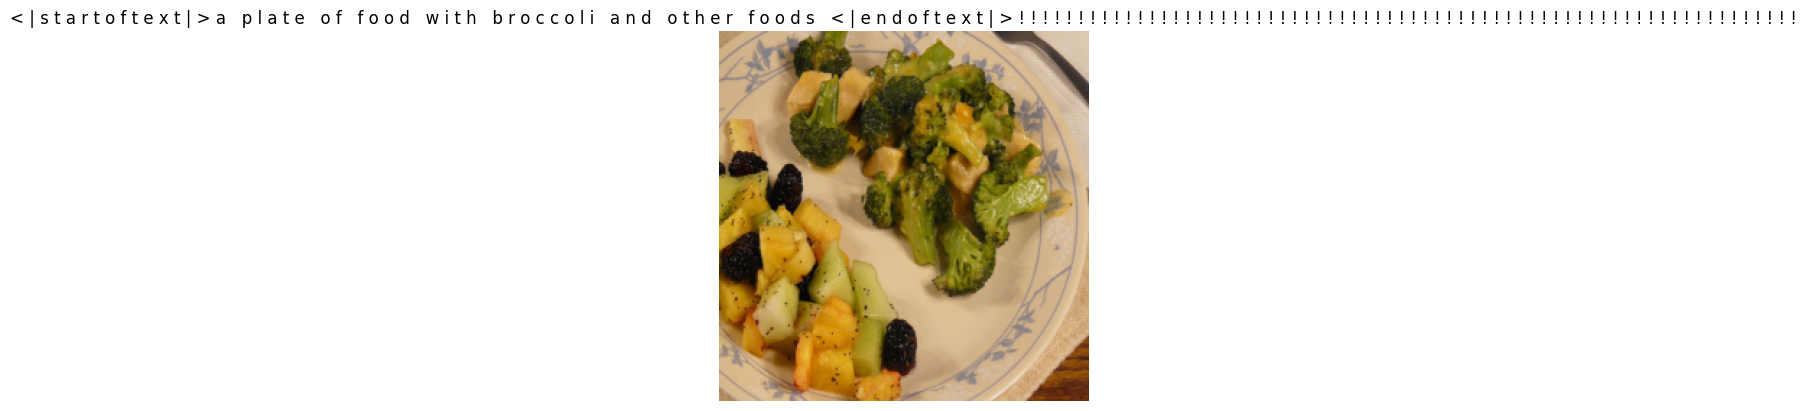

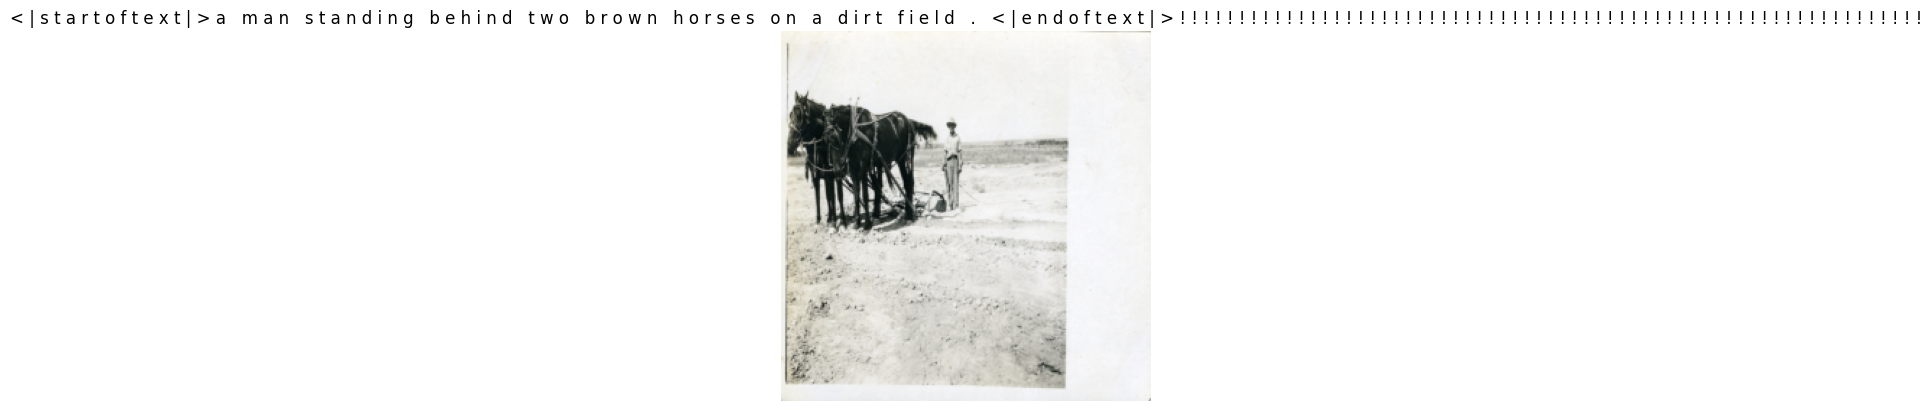

: 

In [67]:
import clip
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Assuming train_images, train_captions, val_images, val_captions are defined

# Decode token IDs to captions
tokenizer = clip.simple_tokenizer.SimpleTokenizer()
def decode_captions(token_ids):
    captions = tokenizer.decode(token_ids)
    return " ".join(captions)

# Decode captions for the first image in the training set
train_caption_1 = decode_captions(train_captions[0][0].tolist())

# Display the image with the decoded caption
img = train_images[0].numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.axis('off')
plt.title(train_caption_1)
plt.show()

# Decode captions for the first image in the validation set
val_caption_1 = decode_captions(val_captions[0][0].tolist())

# Display the image with the decoded caption
img = val_images[0].numpy().transpose(1, 2, 0)
plt.imshow(img)
plt.axis('off')
plt.title(val_caption_1)
plt.show()
